## Imports

In [331]:
import pandas as pd
import numpy as np

from surprise import SVD,Reader,Dataset, accuracy,dump
from surprise.model_selection import train_test_split, cross_validate

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import os
import time
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## load data

In [283]:
#list of movies and there genre
movies = pd.read_csv("../../Data/ml-25m/movies.csv") #load the mushrooms data
#rating given to a movie by a user
ratings = pd.read_csv("../../Data/ml-25m/ratings.csv") #load the mushrooms data
#links to the movies on imdb and tmdb(not really used for recomender system but will be used in final product to show additional info)
links = pd.read_csv("../../Data/ml-25m/links.csv") #load the mushrooms data

## Preprocessing

In [4]:
ratings = ratings.drop(['timestamp'],axis=1)

In [183]:
ratings

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5
...,...,...,...
25000090,162541,50872,4.5
25000091,162541,55768,2.5
25000092,162541,56176,2.0
25000093,162541,58559,4.0


## User-User Collaborative filtering using SVD

In [6]:
#used to parse ratings file
# the rating scale by default is (1,5) which is consistent with our movies dataset ratings
ratingsReader = Reader()

In [7]:
#used to load data from pandas datframe
#must be in format user ids, the item ids, and the ratings
#The movies data was previously formated to be in this formt
surpriseData = Dataset.load_from_df(ratings,ratingsReader)

In [8]:
surpriseData.raw_ratings

[(1, 296, 5.0, None),
 (1, 306, 3.5, None),
 (1, 307, 5.0, None),
 (1, 665, 5.0, None),
 (1, 899, 3.5, None),
 (1, 1088, 4.0, None),
 (1, 1175, 3.5, None),
 (1, 1217, 3.5, None),
 (1, 1237, 5.0, None),
 (1, 1250, 4.0, None),
 (1, 1260, 3.5, None),
 (1, 1653, 4.0, None),
 (1, 2011, 2.5, None),
 (1, 2012, 2.5, None),
 (1, 2068, 2.5, None),
 (1, 2161, 3.5, None),
 (1, 2351, 4.5, None),
 (1, 2573, 4.0, None),
 (1, 2632, 5.0, None),
 (1, 2692, 5.0, None),
 (1, 2843, 4.5, None),
 (1, 3448, 4.0, None),
 (1, 3569, 5.0, None),
 (1, 3949, 5.0, None),
 (1, 4144, 5.0, None),
 (1, 4308, 3.0, None),
 (1, 4325, 5.0, None),
 (1, 4422, 3.0, None),
 (1, 4703, 4.0, None),
 (1, 4973, 4.5, None),
 (1, 5147, 4.0, None),
 (1, 5269, 0.5, None),
 (1, 5684, 2.0, None),
 (1, 5767, 5.0, None),
 (1, 5878, 4.0, None),
 (1, 5912, 3.0, None),
 (1, 5952, 4.0, None),
 (1, 6016, 5.0, None),
 (1, 6370, 4.5, None),
 (1, 6377, 4.0, None),
 (1, 6539, 3.5, None),
 (1, 6711, 5.0, None),
 (1, 6954, 3.5, None),
 (1, 7209, 4.0, 

In [9]:
#split the data into train test split
trainSet,testSet = train_test_split(surpriseData,test_size=0.3)

In [10]:
startTime = time.time()
svd = SVD()

In [11]:
svd.fit(trainSet)
print("SVD train time:",time.time() - startTime)

SVD train time: 1126.1010642051697


In [276]:
#number of unique movies in our training set and amount of latent features after svd
svd.qi.shape

(55121, 100)

### save the model

In [12]:
file_name = os.path.expanduser('modelMovieLens')

In [13]:
dump.dump(file_name, algo=svd)

### RMSE

In [17]:
predict = svd.test(testSet)

In [18]:
accuracy.rmse(predict)

RMSE: 0.7854


0.785412020547681

#### RMSE - Explanation

The Root mean Squared Error of the model is 0.7854 which means that the predicted ratings is within +/- 0.7854 of the actual rating for our model

### comparing predicted vs actual

In [238]:
#comparing predicted vs acutal ratings for user with id 1
user = ratings.loc[ratings['userId'] == 1]

In [239]:
user.reset_index(inplace = True, drop=True) 

In [240]:
userPrediction = pd.DataFrame(columns =['movieId','rating','ratingType']) 

In [241]:
for i in range(len(user)):
    predictedRating = svd.predict(user.loc[i]['userId'],user.loc[i]['movieId'])
    predictedRating = round(predictedRating[3]*2)/2
    newData = {'movieId':user.loc[i]['movieId'],'rating':user.loc[i]['rating'],'ratingType':'actual'}
    userPrediction = userPrediction.append(newData,ignore_index=True)
    newData = {'movieId':user.loc[i]['movieId'],'rating':predictedRating,'ratingType':'predicted'}
    userPrediction = userPrediction.append(newData,ignore_index=True)

In [242]:
userPrediction

,movieId,rating,ratingType
0,296.0,5.0,actual
1,296.0,4.5,predicted
2,306.0,3.5,actual
3,306.0,4.0,predicted
4,307.0,5.0,actual
...,...,...,...
135,27721.0,4.0,predicted
136,31956.0,3.5,actual
137,31956.0,3.5,predicted
138,32591.0,5.0,actual


<AxesSubplot:xlabel='movieId', ylabel='rating'>

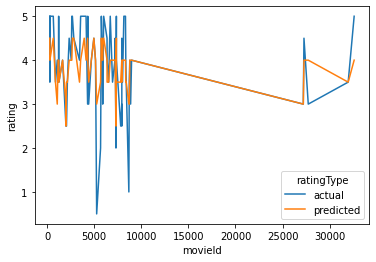

In [243]:
sns.lineplot(data=userPrediction,x='movieId',y='rating',hue='ratingType')

In [267]:
#comparing predicted vs acutal ratings for user with id 10
user = ratings.loc[ratings['userId'] == 10]

In [268]:
user.reset_index(inplace = True, drop=True) 

In [269]:
userPrediction = pd.DataFrame(columns =['movieId','rating','ratingType']) 

In [270]:
for i in range(len(user)):
    predictedRating = svd.predict(user.loc[i]['userId'],user.loc[i]['movieId'])
    predictedRating = round(predictedRating[3]*2)/2
    newData = {'movieId':user.loc[i]['movieId'],'rating':user.loc[i]['rating'],'ratingType':'actual'}
    userPrediction = userPrediction.append(newData,ignore_index=True)
    newData = {'movieId':user.loc[i]['movieId'],'rating':predictedRating,'ratingType':'predicted'}
    userPrediction = userPrediction.append(newData,ignore_index=True)

In [271]:
userPrediction

,movieId,rating,ratingType
0,1.0,3.5,actual
1,1.0,3.5,predicted
2,32.0,4.0,actual
3,32.0,3.5,predicted
4,50.0,5.0,actual
...,...,...,...
101,52767.0,3.5,predicted
102,53000.0,4.0,actual
103,53000.0,3.5,predicted
104,53953.0,3.5,actual


<AxesSubplot:xlabel='movieId', ylabel='rating'>

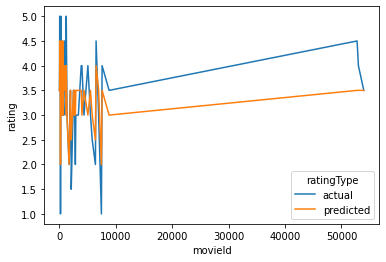

In [272]:
sns.lineplot(data=userPrediction,x='movieId',y='rating',hue='ratingType')

##### observation

From user 1 and user 10 that we compared we can see that the both predicted and actual rating for the users follows a similar patter but not exactly the same value for some movies.  

This can be explained by the RMSE of 0.7854, our predicted ratings are anywhere between +/-0.78 of the actual rating due to which we can see that predicted rating follows similar pattern to actual but does not exactly match it.